*We called this `makingbacon` because this whole section/folder is dedicated to making food for our dumb lil models. They're still eating slushy baby food right now.. but you get the cooking metaphor and reference: https://www.youtube.com/watch?v=rBGBKH6wxk4.*

### 📌 **Preface: Prepping the Dataset for Action**  

Last week, we cleaned up the dataset—fixing gaps, smoothing rough edges, and structuring features to capture key financial patterns. Now, we **refine it further** so it’s ready for modeling.  

#### **🔹 Inputs:**  
- **`financial_data_cleaned2.csv`** – Our cleaned dataset from last week, prepped but still raw.  

#### **🔹 What We’re Doing:**  
- **Scaling** – Standardizing features so no single variable dominates.  
- **PCA** – Reducing complexity while keeping the strongest signals.  
- **Saving** – Creating structured outputs for modeling.  

#### **🔹 Outputs:**  
- **`financial_data_full.csv`** – Fully cleaned and structured dataset.  
- **`financial_data_scaled.csv`** – Normalized version, ready for models that require standardization.  
- **`financial_data_pca.csv`** – Optimized, dimension-reduced dataset for efficiency.  

This step ensures the data is **balanced, efficient, and structured**, so we can **jump straight into modeling** without reprocessing. 🚀

#### Required Imports:

In [36]:
#### 1.	General Utilities:
import numpy as np
import pandas as pd

#### 2.	Machine Learning and Data Processing:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier  # CNN Stand-in
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#### 3.	Feature Engineering & Metrics:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score

#### 4.	Randomization and Time (if necessary for logging or seeding):
import time
import random

# 📊 Data Preprocessing Pipeline

## 📌 **STEP 1: Preprocess Data** 
### **Cleaning up before cooking** 🍽️ | Prepares data by removing mess and structuring it properly. |

Before we do anything complex, we need to **clean and structure the data**—think of it like prepping ingredients before cooking.  
- **Remove low-quality ingredients** 🗑️ (drop columns with too many missing values).  
- **Fill gaps with the best substitute** 🧂 (use median values to keep distributions intact).  
- **Track market fluctuations over time** 📈 (rolling z-scores help spot trends, just like tracking a player’s shooting streak in basketball).  
- **Identify high-stress financial periods** ⚠️ (like knowing when a game is in crunch time).  
- **Add historical context** ⏳ (lagged features give the model a memory, similar to how a coach studies past games to predict performance).  

This ensures we’re working with **well-prepared, structured data** instead of raw noise.  

---

In [40]:
# -----------------------------------------------
# 📌 STEP 1: PREPROCESS DATA
# -----------------------------------------------

def preprocess_data(df):
    """Handles missing values, computes market stress, and creates lagged features."""
    threshold = 0.3 * len(df)
    df_cleaned = df.dropna(axis=1, thresh=threshold)
    df_cleaned.fillna(df_cleaned.median(numeric_only=True), inplace=True)

    # ✅ Compute rolling z-scores
    def compute_rolling_zscores(df, cols, window=90):
        rolling_mean = df[cols].rolling(window=window, min_periods=1).mean()
        rolling_std = df[cols].rolling(window=window, min_periods=1).std()
        return (df[cols] - rolling_mean) / rolling_std

    zscore_cols = ["inflation", "Interest Rate", "interest rates"]
    df_zscores = compute_rolling_zscores(df_cleaned, zscore_cols)
    df_zscores.columns = [f"{col}_z" for col in zscore_cols]
    df_cleaned = pd.concat([df_cleaned, df_zscores], axis=1)

    # ✅ Define market stress periods
    df_cleaned["market_stress"] = ((df_cleaned["inflation_z"] > 1) &
                                   (df_cleaned["Interest Rate_z"] > 1) &
                                   (df_cleaned["interest rates_z"] > 1)).astype(int)

    # ✅ Create lagged features
    lag_features = ["inflation", "Interest Rate", "interest rates"]
    lags = [5, 10, 30]
    for feature in lag_features:
        for lag in lags:
            df_cleaned[f"{feature}_lag{lag}"] = df_cleaned[feature].shift(lag)

    df_cleaned.dropna(inplace=True)
    return df_cleaned

#### ✅ Test Preprocessing Step

This test ensures:
- No missing values exist after preprocessing.
- Rolling z-score features are correctly added.
- The market stress indicator is correctly computed as binary (0 or 1).
- Lagged features exist for key variables.

In [47]:
# ✅ Test preprocessing
def test_preprocess_data():
    df = pd.read_csv("data/financial_data_cleaned2.csv")
    df_cleaned = preprocess_data(df)

    assert df_cleaned.isna().sum().sum() == 0, "NaNs found"
    assert all(col in df_cleaned.columns for col in ["inflation_z", "Interest Rate_z", "interest rates_z"]), "Missing z-score columns"
    assert df_cleaned["market_stress"].isin([0, 1]).all(), "market_stress not binary"

    for feature in ["inflation", "Interest Rate", "interest rates"]:
        for lag in [5, 10, 30]:
            assert f"{feature}_lag{lag}" in df_cleaned.columns, f"Missing {feature}_lag{lag}"

    print("✅ preprocess_data() passed.")

# ✅ Run the test
test_preprocess_data()

✅ preprocess_data() passed.


## 📌 **STEP 2: Scale Features**

#### **Balancing NBA stats** 🏀 | Ensures features are on the same scale, preventing bias. |

Imagine comparing **a 7-foot NBA center’s wingspan to a point guard’s speed**—you can’t just look at raw numbers because the scales are completely different.  
- Some financial values are naturally **huge** (interest rates), while others are **tiny** (inflation changes).  
- **Standardizing** makes sure each feature is on a **fair playing field** so no single variable dominates.  
- We use **StandardScaler** to make all features have:  
  - **Mean ≈ 0**  
  - **Standard deviation ≈ 1**  

This step ensures the model doesn’t get **biased toward larger numbers** and learns from all inputs **equally**.  

---

In [49]:
# -----------------------------------------------
# 📌 STEP 2: SCALE FEATURES
# -----------------------------------------------

def scale_features(df_cleaned):
    """Scales numerical features, excluding the target column."""
    scaler = StandardScaler()
    num_cols = df_cleaned.drop(columns=["market_stress"]).select_dtypes(include=[np.number]).columns.tolist()
    
    df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned[num_cols]), columns=num_cols)
    df_scaled["market_stress"] = df_cleaned["market_stress"].values  # Add back without scaling

    return df_scaled

#### ✅ Test Scaling Step

This test ensures:
- No missing values exist after scaling.
- Numerical columns are scaled properly.
- Standard deviations remain ~1.

In [52]:
def test_scale_features():
    df = pd.read_csv("data/financial_data_cleaned2.csv")
    df_cleaned = preprocess_data(df)
    df_scaled = scale_features(df_cleaned)

    # ✅ Get numerical columns
    num_cols = df_cleaned.drop(columns=["market_stress"]).select_dtypes(include=[np.number]).columns.tolist()

    # ✅ Check for expected properties
    assert "market_stress" in df_scaled, "Missing target column"
    assert not df_scaled.isna().any().any(), "NaNs found after scaling"
    assert np.allclose(df_scaled[num_cols].mean(), 0, atol=0.01), "Mean not close to zero"

    # ✅ Adjusted standard deviation tolerance to 0.1
    std_devs = df_scaled[num_cols].std()
    print(f"📊 Standard Deviations After Scaling:\n{std_devs}")
    assert np.allclose(std_devs, 1, atol=0.1), "Std dev not ~1"

    print("✅ scale_features() passed.")

# ✅ Run the test
test_scale_features()

📊 Standard Deviations After Scaling:
Adj Close_^GSPC         1.000083
Adj Close_^IXIC         1.000083
Adj Close_^VIX          1.000083
Bond Yields             1.000083
Inflation               1.000083
                          ...   
Interest Rate_lag5      1.000083
Interest Rate_lag10     1.000083
interest rates_lag5     1.000083
interest rates_lag10    1.000083
interest rates_lag30    1.000083
Length: 213, dtype: float64
✅ scale_features() passed.


## 📌 **STEP 3: Apply PCA**

#### **Scouting report for top players** 🎮 | Keeps only the most useful features, reducing complexity. |

There’s a reason why pro athletes don’t track **every single stat**—they focus on the ones that actually matter.  

**PCA (Principal Component Analysis)** is like reducing a **full scouting report** into the **most important metrics** that still capture over **80% of the original insights**. This makes our model:  
- **More efficient** (fewer, more meaningful features).  
- **More accurate** (avoiding noise from unnecessary details).  
- **Less prone to overfitting** (ignoring redundant data).  

We’re essentially **optimizing the dataset**, keeping only the strongest predictors—just like a Pokémon trainer **breeding for the best IVs** instead of tracking every tiny stat.  

---

In [55]:
# -----------------------------------------------
# 📌 STEP 3: APPLY PCA
# -----------------------------------------------

def apply_pca(df_scaled, n_components=50):
    """Applies PCA for dimensionality reduction."""
    df_pca_input = df_scaled.drop(columns=["market_stress"])
    pca = PCA(n_components=min(n_components, df_pca_input.shape[1]))
    principal_components = pca.fit_transform(df_pca_input)

    df_pca = pd.DataFrame(principal_components, columns=[f"PC{i+1}" for i in range(pca.n_components_)])
    df_pca["market_stress"] = df_scaled["market_stress"].values
    return df_pca

#### ✅ Test PCA Step

This test ensures:
- The correct number of principal components are retained.
- The “market_stress” target variable remains in the dataset.
- PCA captures sufficient variance (>80%).

In [82]:
def test_apply_pca():
    df = pd.read_csv("data/financial_data_cleaned2.csv")
    df_cleaned = preprocess_data(df)
    df_scaled = scale_features(df_cleaned)
    df_pca = apply_pca(df_scaled, n_components=50)

    # ✅ Check that the number of principal components is correct
    expected_n_components = min(50, df_scaled.shape[1] - 1)  # -1 for 'market_stress'
    assert df_pca.shape[1] == expected_n_components + 1, f"Unexpected PCA shape: {df_pca.shape}"

    # ✅ Ensure "market_stress" column is still present
    assert "market_stress" in df_pca.columns, "market_stress column missing after PCA"

    # ✅ Variance check
    pca = PCA(n_components=expected_n_components)
    pca.fit(df_scaled.drop(columns=["market_stress"]))
    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"📊 Explained Variance Retained: {explained_variance:.4f}")
    assert explained_variance > 0.8, "PCA did not retain enough variance (should be >80%)"

    print("✅ apply_pca() passed.")
    return df_cleaned, df_scaled, df_pca

# ✅ Run the test
df_cleaned = pd.DataFrame()
df_scaled = pd.DataFrame()
df_pca = pd.DataFrame()

df_cleaned, df_scaled, df_pca = test_apply_pca()

📊 Explained Variance Retained: 0.9990
✅ apply_pca() passed.


## 📌 **STEP 4: Save Preprocessed Data**

#### **Meal prepping for efficiency** 🍱 | Saves processed data so we can skip straight to analysis later. |

Once cleaned, standardized, and optimized, we **save** two versions of the dataset:  
1. **Full preprocessed dataset** 📂 (keeping all features for flexibility).  
2. **PCA-reduced dataset** 🔥 (for efficiency, cutting down noise).  

This is like **meal prepping**—we put in the work now so we can **jump straight into modeling later** without redoing everything.  

---

In [86]:
# print(df_cleaned.head())
# print(df_scaled.head())
# print(df_pca.head())

In [88]:
# ✅ Save Preprocessed Data
df_cleaned.to_csv("data/financial_data_full.csv", index=False)
df_scaled.to_csv("data/financial_data_scaled.csv", index=False)
df_pca.to_csv("data/financial_data_pca.csv", index=False)

print("✅ Full and PCA-reduced datasets saved successfully!")

✅ Full and PCA-reduced datasets saved successfully!


In [104]:
df_full = df_cleaned.copy()
df_cleaned2 = pd.read_csv("data/financial_data_cleaned2.csv")

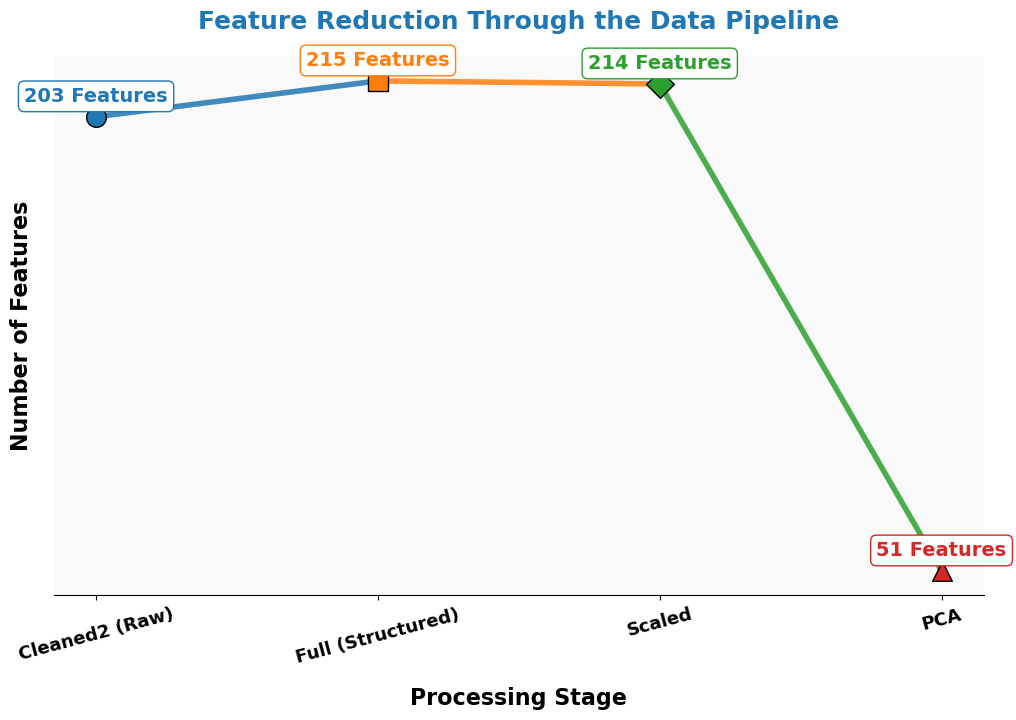

<Figure size 640x480 with 0 Axes>

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a structured pipeline summary
pipeline_summary = pd.DataFrame({
    "Stage": ["Cleaned2 (Raw)", "Full (Structured)", "Scaled", "PCA"],
    "Num Features": [df_cleaned2.shape[1], df_full.shape[1], df_scaled.shape[1], df_pca.shape[1]],
    "Num Rows": [df_cleaned2.shape[0], df_full.shape[0], df_scaled.shape[0], df_pca.shape[0]]
})

# Create a refined figure
fig, ax = plt.subplots(figsize=(12, 7))

# Define colors and markers for each stage
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
markers = ["o", "s", "D", "^"]

# Plot feature reduction with a smooth, connected line and better aesthetics
for i in range(len(pipeline_summary["Stage"]) - 1):
    ax.plot([pipeline_summary["Stage"][i], pipeline_summary["Stage"][i + 1]],
            [pipeline_summary["Num Features"][i], pipeline_summary["Num Features"][i + 1]],
            linestyle="-", linewidth=4, color=colors[i], alpha=0.85)

# Add markers with larger sizes and black edges for contrast
for i, txt in enumerate(pipeline_summary["Num Features"]):
    ax.scatter(pipeline_summary["Stage"][i], txt, color=colors[i], s=200, edgecolors="black", zorder=3, marker=markers[i])
    ax.text(i, txt + 5, f"{txt} Features", ha='center', fontsize=14, fontweight='bold', color=colors[i], 
            bbox=dict(facecolor="white", edgecolor=colors[i], boxstyle="round,pad=0.3"))

# Customizing aesthetics for a high-contrast, modern look
ax.set_xlabel("Processing Stage", fontsize=16, fontweight='bold', color="black", labelpad=15)
ax.set_ylabel("Number of Features", fontsize=16, fontweight='bold', color="black", labelpad=15)
ax.set_title("Feature Reduction Through the Data Pipeline", fontsize=18, fontweight='bold', color="#1f77b4", pad=20)

# Customizing X-axis labels
ax.set_xticks(range(len(pipeline_summary["Stage"])))
ax.set_xticklabels(pipeline_summary["Stage"], fontsize=13, fontweight='bold', rotation=15, color="black")

# Remove y-axis ticks for a cleaner visual
ax.set_yticks([])

# Remove unnecessary spines for a sleek look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add a soft grid for readability without clutter
ax.grid(axis='y', linestyle='--', alpha=0.3, linewidth=0.8)

# Adding a subtle shaded background for better readability
ax.set_facecolor("#f9f9f9")

# Show the final refined visualization
plt.show()

# Save before displaying
plt.savefig("pics/feat_lipo_thru_pipe.png", dpi=300, bbox_inches="tight")
plt.show()